In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.optimize import minimize
from tqdm.auto import tqdm

import pandas as pd

import yfinance as yf
from pandas_datareader import data as pdr

import warnings
warnings.filterwarnings("ignore")
import os
os.environ['PYTHONWARNINGS']='ignore::UserWarning'
warnings.filterwarnings('ignore', "Intel MKL ERROR")

In [3]:
yf.pdr_override() # <== that's all it takes :-)

In [4]:
start_date="2000-01-01"
end_date="2024-04-24"

tickers = ["EURUSD=X", "GBPUSD=X", "CHFUSD=X", "JPYUSD=X", "CNYUSD=X", "CADUSD=X", "GBPUSD=X", 
           "UYUUSD=X"]
# excluding these b/c some errors in data downloads:
#   "CLPUSD=X", "AUDUSD=X", "BRLUSD=X"
# top8ticker2data = {}
ticker2data = {}
global_min_date = None
global_max_date = None
for t in tickers:
    df = pdr.get_data_yahoo(t, start=start_date, end=end_date)
    ticker2data[t[0:3]] = df
    # if tickers.index(t) < 8:
    #     top8ticker2data[t] = df
    if global_min_date is None or df.index[0] > global_min_date:
        global_min_date = df.index[0]
    if global_max_date is None or df.index[-1] < global_max_date:
        global_max_date = df.index[-1]
        
# get reference argentine peso data
ars_df = pdr.get_data_yahoo("ARSUSD=X", start=start_date, end=end_date)
# update global min-max dates based on data from arg
if ars_df.index[0] > global_min_date:
    global_min_date = ars_df.index[0]
if ars_df.index[-1] < global_max_date:
    global_max_date = ars_df.index[-1]

print(global_min_date, global_max_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

2003-12-01 00:00:00 2024-04-23 00:00:00


In [5]:

# trim all dataframes to be within global min/max
full_date_range = pd.date_range(start=global_min_date, end=global_max_date)
for t in tickers:
    dff = ticker2data[t[0:3]].loc[global_min_date:global_max_date]
    dff = dff.reindex(full_date_range).ffill()
    dff = dff[dff.index.dayofweek < 5]  # only weekdays
    ticker2data[t[0:3]] = dff
dff = ars_df.loc[global_min_date:global_max_date]
dff = dff.reindex(full_date_range).ffill()
dff = dff[dff.index.dayofweek < 5]  # only weekdays
ars_df = dff

In [6]:
# normalize according to the paper

close_df = pd.DataFrame()
for ticker, data in ticker2data.items(): 
    close_df[ticker] = data['Adj Close']
close_df['USD'] = 1
close_df['ARS'] = ars_df['Adj Close']

currencies_for_basket = ['EUR', 'GBP', 'JPY', 'CNY', 'USD', 'CHF', 'CAD', 'UYU']
# currencies_for_basket = ['EUR', 'GBP', 'JPY', 'CNY', 'USD']
close_df = close_df[currencies_for_basket]
# normalize the prices
n_curr = len(tickers) + 2 # add in argentina and usd
num_obs = len(close_df)
RNVAL_df = pd.DataFrame()
for currency in close_df.columns:
    df_adjusted = close_df.div(close_df[currency], axis=0)
    RNVAL = pd.Series(num_obs)
    for i in range(num_obs):
        RNVAL[i] = np.prod(df_adjusted.iloc[i]/df_adjusted.iloc[0]) ** (1/n_curr)
    
    RNVAL_df[currency] = RNVAL 
RNVAL_df.set_index(close_df.index, inplace=True)

# make ohlc data (needed for the backtesting.py framework) w/ normalized prices
ticker2data_normalized = {}
tickers = []
for t in RNVAL_df.columns:
    if t is not 'ARS':  # we don't want ARS in the basket
        p = RNVAL_df[t]
        df = pd.DataFrame()
        df['Open'] = df['High'] = df['Low'] = df['Close'] = p
        df.index = RNVAL_df.index
        ticker2data_normalized[t] = df
        tickers.append(t)

In [7]:
def objective_fn(w, variances, cov_matrix):
    n = len(w)
    sum_var_squared = np.sum(w**2 * variances**2)
    sum_cov = 2 * np.dot(w, np.dot(cov_matrix, w))
    return sum_var_squared + sum_cov

def constraint(w):
    return 1 - np.sum(w)

def optimize_weights(df):
    cov_matrix = df.cov()
    variances = df.var()
    n = cov_matrix.shape[0]
    initial_guess = np.ones(n) / n
    # initial_guess = np.random.rand(n) / np.sum(n)

    EPS = 0.001

    result = minimize(objective_fn, 
                      initial_guess, 
                      method='L-BFGS-B',
                      args=(variances, cov_matrix), 
                      bounds=[(EPS, 1-EPS)] * len(variances), 
                      constraints={'type': 'eq', 'fun': constraint},
                      options={'maxiter': 10000}
                      )
    
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

In [8]:
def compute_portfolio_value(df, weights):
    return np.dot(df, weights)

In [9]:
lookback = 90
rebalance_period = 90
# basket = []
df_normalized_list = []
df_raw_mvo_list = []
df_raw_eq_list = []
ticker2data['USD'] = ticker2data['EUR'].copy()
ticker2data['USD']['Open'] = ticker2data['USD']['High'] = ticker2data['USD']['Low'] = ticker2data['USD']['Close'] = ticker2data['USD']['Adj Close'] = 1
for i in tqdm(range(lookback, len(RNVAL_df), rebalance_period)):
    df_i = RNVAL_df.iloc[i-lookback:i][currencies_for_basket]
    # print(df_i)
    w = optimize_weights(df_i)
    c2w = dict(zip(currencies_for_basket, w))
    # apply these weights to the next rebalance_period days
    df_j = RNVAL_df.iloc[i:i+rebalance_period][currencies_for_basket].copy()
    df_normalized_subset = df_j.copy()
    
    # compute overall portfolio return
    df_normalized_subset['SAC (MVO)'] = np.dot(df_normalized_subset, w)
    df_normalized_list.append(df_normalized_subset)
    
    # compute portfolio using these weights but raw prices
    c2raw = {}
    mvo_portfolio_sum = 0
    eq_portfolio_sum = 0
    for c in currencies_for_basket:
        xx = ticker2data[c]['Adj Close'].loc[df_j.index]
        c2raw[c] = xx
        mvo_portfolio_sum += xx * c2w[c]
        eq_portfolio_sum += xx / len(currencies_for_basket)
    df_raw = pd.DataFrame(c2raw)
    df_raw['SAC (MVO)'] = mvo_portfolio_sum
    df_raw_mvo_list.append(df_raw)
    df_raw['SAC (EQ)'] = eq_portfolio_sum
    df_raw_eq_list.append(df_raw)

df_output = pd.concat(df_normalized_list)
df_output_raw = pd.concat(df_raw_mvo_list)
df_output_eq = pd.concat(df_raw_eq_list)


  0%|          | 0/59 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


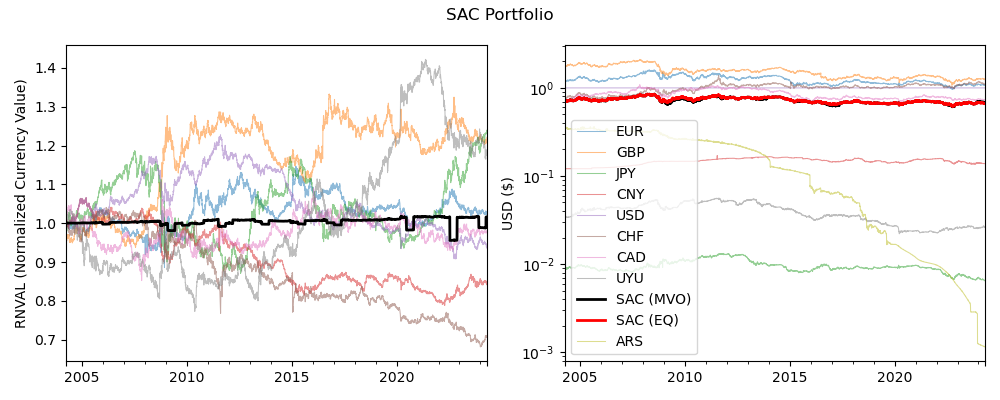

In [10]:
plot_currencies = currencies_for_basket.copy()
plot_currencies.append('SAC (MVO)')
plot_df = df_output[plot_currencies]
# plot_df = plot_df.divide(plot_df['USD'], axis=0) # normalize to USD
# plot_df.plot()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
axx = ax[0]
for p in plot_currencies:
    alpha = 1 if 'SAC' in p else 0.5
    line_width = 2 if 'SAC' in p else 0.75
    if 'SAC' in p:
        plot_df[p].plot(label=p, alpha=alpha, linewidth=line_width, color='k', ax=axx)
    else:
        plot_df[p].plot(label=p, alpha=alpha, linewidth=line_width, ax=axx)
# axx.legend()
axx.set_ylabel('RNVAL (Normalized Currency Value)')

axx = ax[1]
plot_currencies = currencies_for_basket.copy()
plot_currencies.append('SAC (MVO)')
plot_currencies.append('SAC (EQ)')
plot_df = df_output_raw[plot_currencies]
# add argentina
plot_df['ARS'] = ars_df['Adj Close'].loc[plot_df.index]
for p in plot_df.columns:
    alpha = 1 if 'SAC' in p else 0.5
    line_width = 2 if 'SAC' in p else 0.75
    if 'SAC' in p:
        if 'MVO' in p:
            plot_df[p].plot(label=p, alpha=alpha, linewidth=line_width, color='k', ax=axx)
        elif 'EQ' in p:
            plot_df[p].plot(label=p, alpha=alpha, linewidth=line_width, color='r', ax=axx)
    else:
        plot_df[p].plot(label=p, alpha=alpha, linewidth=line_width, ax=axx)

axx.legend()
axx.set_yscale('log')
axx.set_ylabel('USD ($)')

plt.tight_layout()
plt.suptitle('SAC Portfolio')
plt.tight_layout()
plt.savefig('SAC_debug.png')

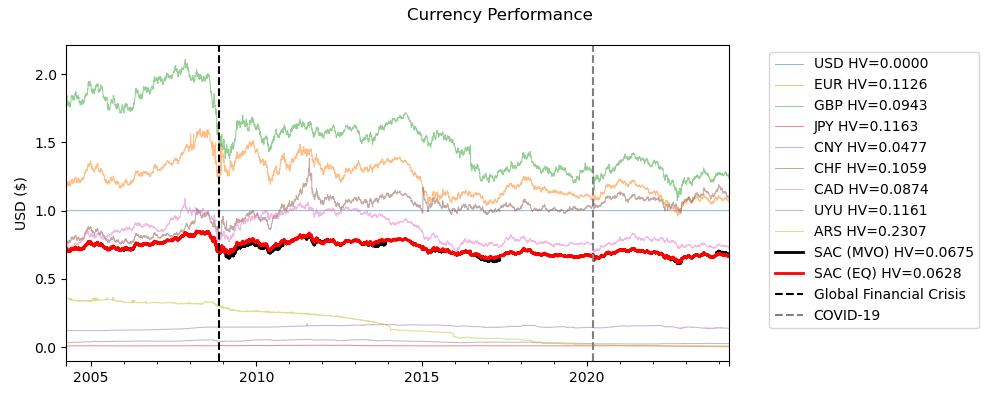

In [12]:
fig, axx = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
plot_currencies = currencies_for_basket.copy()
plot_currencies.append('SAC (MVO)')
plot_currencies.append('SAC (EQ)')
plot_df = df_output_raw[plot_currencies]
# add argentina
plot_df['ARS'] = ars_df['Adj Close'].loc[plot_df.index]
plot_order = ['USD', 'EUR', 'GBP', 'JPY', 'CNY', 'CHF', 'CAD', 'UYU', 'ARS', 'SAC (MVO)', 'SAC (EQ)']
for p in plot_order:
    alpha = 1 if 'SAC' in p else 0.5
    line_width = 2 if 'SAC' in p else 0.75
    yy = plot_df[p]
    log_returns = np.log(yy.pct_change() + 1)
    hv = log_returns.std() * np.sqrt(252)
    l = p + ' HV=%0.04f' % hv
    if 'SAC' in p:
        if 'MVO' in p:
            plot_df[p].plot(label=l, alpha=alpha, linewidth=line_width, color='k', ax=axx)
        elif 'EQ' in p:
            plot_df[p].plot(label=l, alpha=alpha, linewidth=line_width, color='r', ax=axx)
    else:
        plot_df[p].plot(label=l, alpha=alpha, linewidth=line_width, ax=axx)

axx.axvline(x='11-20-2008', color='k', linestyle='--', label='Global Financial Crisis')
axx.axvline(x='03-16-2020', color='grey', linestyle='--', label='COVID-19')
axx.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axx.set_ylabel('USD ($)')
plt.suptitle('Currency Performance')
plt.tight_layout()

plt.savefig('SAC.png')